<a href="https://colab.research.google.com/github/Saltizm/Data-mining-group-project/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import sklearn as sk;
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;
import tqdm;
import os;
import sys;

In [56]:
# # # mount
# from google.colab import drive
# drive.mount('/content/drive')

In [57]:
if os.path.isdir(r'C:\Users\User\Desktop\Data-mining-group-project'):
    os.chdir(r'C:\Users\User\Desktop\Data-mining-group-project') #local
elif os.path.isdir(r'/content/drive/MyDrive/data mining'):
    os.chdir(r'/content/drive/MyDrive/data mining') #google drive
try:
    train = pd.read_csv(open('UNSW_NB15_training-set.csv', encoding='utf-8'))
    test = pd.read_csv(open('UNSW_NB15_testing-set.csv', encoding='utf-8'))
except FileNotFoundError as e:
    print(f"error: {e}\nTry changing the training data directory in 'os.chdir'")

In [162]:
# Set parameters
OUTLIER_THRESHOLD = 0.1
FEATURE_THRESHOLD = 0.1
BIN_THRESHOLD = 0.1

In [59]:
np.random.seed(42)

In [60]:
# if data too big (use for testing)
# train = train.sample(frac=0.1)
# test = test.sample(frac=0.1)

In [61]:
print(train.shape, test.shape)
# 45 attributes

(17534, 45) (8233, 45)


In [62]:
train.isnull().any(axis=1).sum()

0

In [63]:
test.isnull().any(axis=1).sum()

0

In [64]:
# import files
train = train.sample(frac=1)
test = test.sample(frac=1)
x_train, y_train = train.iloc[:, :-2], train.iloc[:, -2:]
x_test, y_test = test.iloc[:, :-2], test.iloc[:, -2:]

In [65]:
y_train.columns

Index(['attack_cat', 'label'], dtype='object')

In [135]:
def show_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (lower_bound, upper_bound)

# data cleaning (replacement)
def replace_outliers_iqr(df, cols):
    for col in cols:
        if col in df.columns:
            lower_bound, upper_bound = show_outliers_iqr(df[col])
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# data filtering
def remove_outliers_iqr(df, cols):
    overall_mask = pd.Series(True, index=df.index)

    for col in cols:
        if col in df.columns:
            lower_bound, upper_bound = show_outliers_iqr(df[col])
            col_mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
            overall_mask = overall_mask & col_mask

    df = df[overall_mask]
    return df

def risky_show_shape(*arg):
    if len(arg) == 2:
        print("train/test")
        print(arg[0].shape, arg[1].shape)
    else:
        print("x_train/x_test/y_train/y_test")
        for df in arg:
            print(df.shape)

def run_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

def plot_histograms(df, numerical_cols, frac=0.1, title='graph'):
    df = df.copy().sample(frac=frac)
    # Filter numerical_cols to only include those present in binned_x_train
    columns_to_plot = [col for col in numerical_cols if col in df.columns]

    # Calculate grid dimensions
    num_plots = len(columns_to_plot)
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols # Equivalent to ceil(num_plots / num_cols)

    plt.figure(figsize=(20, num_rows * 5)) # Adjust figure size for better readability

    for i, col in enumerate(columns_to_plot):
        ax = plt.subplot(num_rows, num_cols, i + 1) # Create subplot
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Hide any unused subplots if the last row is not full
    for j in range(i + 1, num_rows * num_cols):
        plt.subplot(num_rows, num_cols, j + 1).set_visible(False)

    plt.title(title)
    plt.tight_layout()
    plt.show()

# def bin_decision(unique_series, threshold=0.2):
#     keep = []

#     val_count = unique_series.value_counts()
#     for col in val_count.index:
#         if val_count[col] / unique_series.shape[0] > threshold:
#             keep.append(col)
#     return keep

# def binning(df, col, values):
#     df = df.copy()

#     for val in values:
#         df[col].replace(val, 'Others', inplace=True)
#     return df

class Plot(BaseEstimator, TransformerMixin):
    def __init__(self, frac=0.1, title='graph'):
        self.frac = frac
        self.title = title

    def fit(self, X, y=None):
        print(X.shape)
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            # Create a DataFrame from the numpy array for plotting purposes
            temp_df = pd.DataFrame(X)
            cols_to_plot = list(range(X.shape[1]))
        elif isinstance(X, pd.DataFrame):
            temp_df = X
            cols_to_plot = X.columns.tolist()
        else:
            raise TypeError("Input must be a pandas DataFrame or a numpy array.")

        plot_histograms(temp_df, cols_to_plot, self.frac, self.title)
        return X

class Add_feature(BaseEstimator, TransformerMixin):
    def __init__(self, feature_1, feature_2):
        self.feature_1 = feature_1
        self.feature_2 = feature_2

    def fit(self, X, y=None):
        print(X.shape)
        return self

    def transform(self, X):
        X = X.copy()
        X['new_feature'] = X[self.feature_1] + X[self.feature_2]
        return X

class Ratio_feature(BaseEstimator, TransformerMixin):
    def __init__(self, feature_1, feature_2):
        self.feature_1 = feature_1
        self.feature_2 = feature_2
        if self.feature_2 == 0:
            self.feature_2 = 1

    def fit(self, X, y=None):
        print(X.shape)
        return self

    def transform(self, X):
        X = X.copy()
        X['new_feature'] = X[self.feature_1] / X[self.feature_2]
        return X

class capping(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        print(X.shape)
        return self

    def transform(self, X):
        output = replace_outliers_iqr(X, self.cols)
        return output

class filtering(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y):
        return self

    def transform(self, X):
        output = remove_outliers_iqr(X, self.cols)
        return output

class Threshold_binning(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.2, other_label="Others"):
        self.threshold = threshold
        self.other_label = other_label

    def fit(self, X, y=None):
        print(X.shape)
        X = pd.DataFrame(X).copy()
        self.keep_ = {}

        for col in X.columns:
            freq = X[col].value_counts(normalize=True)
            self.keep_[col] = freq[freq > self.threshold].index

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in X.columns:
            keep = self.keep_.get(col, [])
            X[col] = X[col].where(X[col].isin(keep), self.other_label)
        return X

class Pearson_feature_selection(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def fit(self, X, y):
        # Convert to DataFrame for correlation calculation
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        y_series = pd.Series(y) if not isinstance(y, pd.Series) else y

        # Calculate correlation between each feature and target
        correlations = X_df.corrwith(y_series).abs()

        # Keep features with correlation above threshold
        self.keep_ = correlations > self.threshold
        self.n_features_in_ = X_df.shape[1]
        self.n_features_out_ = self.keep_.sum()

        print(f'Pearson selection: {self.n_features_in_} -> {self.n_features_out_} features')

        return self

    def transform(self, X):
        # Always work with the boolean mask on columns
        if isinstance(X, pd.DataFrame):
            return X.loc[:, self.keep_]
        else:
            return X[:, self.keep_.values]
class Pearson_feature_selection(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def fit(self, X, y):
        # Convert to DataFrame/Series and align indices
        X_df = pd.DataFrame(X).reset_index(drop=True) if not isinstance(X, pd.DataFrame) else X.reset_index(drop=True)
        y_series = pd.Series(y).reset_index(drop=True) if not isinstance(y, pd.Series) else y.reset_index(drop=True)

        # Calculate absolute correlation with target
        correlations = X_df.corrwith(y_series).abs().fillna(0)

        # Select features above threshold
        self.keep_ = correlations > self.threshold
        self.n_features_in_ = X_df.shape[1]
        self.n_features_out_ = self.keep_.sum()

        print(f'Pearson selection: {self.n_features_in_} -> {self.n_features_out_} features (threshold={self.threshold})')

        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.loc[:, self.keep_]
        else:
            return X[:, self.keep_.values]

class SafeLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, replacement_value=1e-10):
        self.replacement_value = replacement_value

    def fit(self, X, y=None):
        print(X.shape)
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Replace zeros
        if hasattr(X, 'iloc'):  # DataFrame
            X_transformed = X.replace(0, self.replacement_value)
            # Apply log1p
            return np.log1p(X_transformed)
        else:  # NumPy array
            X_transformed[X == 0] = self.replacement_value
            return np.log1p(X_transformed)


message = """
plot_histograms(frac=0.1) -
plot a sampled subset of the data.

show_outliers_iqr(series) -
return an array where index=0 is the lower bound and index=1 is the upper bound.

replace_outliers_iqr(df, cols) -
creates a copy of "df". replace the samples with attributes > upper_bound or < lower_bound with upper_bound or lower_bound.

remove_outliers_iqr(df, cols) -
creates a copy of "df". remove the samples with attributes > upper_bound or < lower_bound.

risky_show_shape(*data) -
in the format of train/test. Or x_train, x_test, y_train, y_test.

run_model(model, x_train, y_train, x_test, y_test) -
runs the model and returns the prediction.

bin_decision(unique_series, threshold=0.2) -
receives a series df['col'].
get a list of value that represent less than x% of the total.

binning(df, col, values) -
replace a list of values with 'others' for one hot encoding later on.

---------------------------------------------------------------------------------------------------------------------------

User defined Transformer;

Plot(BaseEstimator, TransformerMixin) -
wrapper function for plot_histograms

Add_feature(BaseEstimator, TransformerMixin) -
Transformer that adds two numerical features to create a new secondary feature.

Ratio_feature(BaseEstimator, TransformerMixin) -
Transformer that divide two numerical features to create a new secondary feature.
if denominator value=0. reassign it to 1.

Capping/Filtering(BaseEstimator, TransformerMixin) -
wrapper function for replace_outliers_iqr/remove_outliers_iqr

Threshold_binning(BaseEstimator, TransformerMixin) -
bins values below a threshold into 'others'. Replacement for defunct binning and bin decision function rip

Pearson_feature_selection(BaseEstimator, TransformerMixin) -
select features based on corr coe

Safe_log_transform(BaseEstimator, TransformerMixin) -
replace zeros with a small number. Then apply log1p.
"""
print(message)


plot_histograms(frac=0.1) -
plot a sampled subset of the data.

show_outliers_iqr(series) -
return an array where index=0 is the lower bound and index=1 is the upper bound.

replace_outliers_iqr(df, cols) -
creates a copy of "df". replace the samples with attributes > upper_bound or < lower_bound with upper_bound or lower_bound.

remove_outliers_iqr(df, cols) -
creates a copy of "df". remove the samples with attributes > upper_bound or < lower_bound.

risky_show_shape(*data) -
in the format of train/test. Or x_train, x_test, y_train, y_test.

run_model(model, x_train, y_train, x_test, y_test) -
runs the model and returns the prediction.

bin_decision(unique_series, threshold=0.2) -
receives a series df['col'].
get a list of value that represent less than x% of the total.

binning(df, col, values) -
replace a list of values with 'others' for one hot encoding later on.

----------------------------------------------------------------------------------------------------------------------

In [67]:
# find numerical and non numerical fields
numerical_cols = x_train.select_dtypes(include=np.number).columns
non_numerical_cols = x_train.select_dtypes(exclude=np.number).columns

In [68]:
# find continuous and uniary fields (low and high cardinality)

low_cardinality_cols = []
high_cardinality_cols = []
continuous_cols = []

# Define a threshold for low cardinality. For example, less than 20 unique values.
CARDINALITY_THRESHOLD = 50

for col in numerical_cols:
    if col in ['id', 'label']:
        continue

    unique_count = x_train[col].nunique()
    if unique_count <= CARDINALITY_THRESHOLD:
        low_cardinality_cols.append(col)
    else:
        continuous_cols.append(col)

# Non-numerical columns can also be high cardinality if they have many unique categorical values
# This step categorizes based on numerical data first.
# Let's consider non-numerical columns for high cardinality if they have many unique values
for col in non_numerical_cols:
    if col in ['id', 'label']:
        continue
    unique_count = x_train[col].nunique()
    if unique_count > CARDINALITY_THRESHOLD:
        high_cardinality_cols.append(col)
    else:
        low_cardinality_cols.append(col)

In [69]:
print(f"Continuous Columns ({len(continuous_cols)}): {continuous_cols}")
print(f"Low Cardinality Columns ({len(low_cardinality_cols)}): {low_cardinality_cols}")
print(f"High Cardinality (Non-numerical) Columns ({len(high_cardinality_cols)}): {high_cardinality_cols}")

Continuous Columns (25): ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'response_body_len', 'ct_srv_src', 'ct_dst_src_ltm', 'ct_srv_dst']
Low Cardinality Columns (16): ['sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'is_sm_ips_ports', 'service', 'state']
High Cardinality (Non-numerical) Columns (1): ['proto']


### Histograms for Continuous Columns

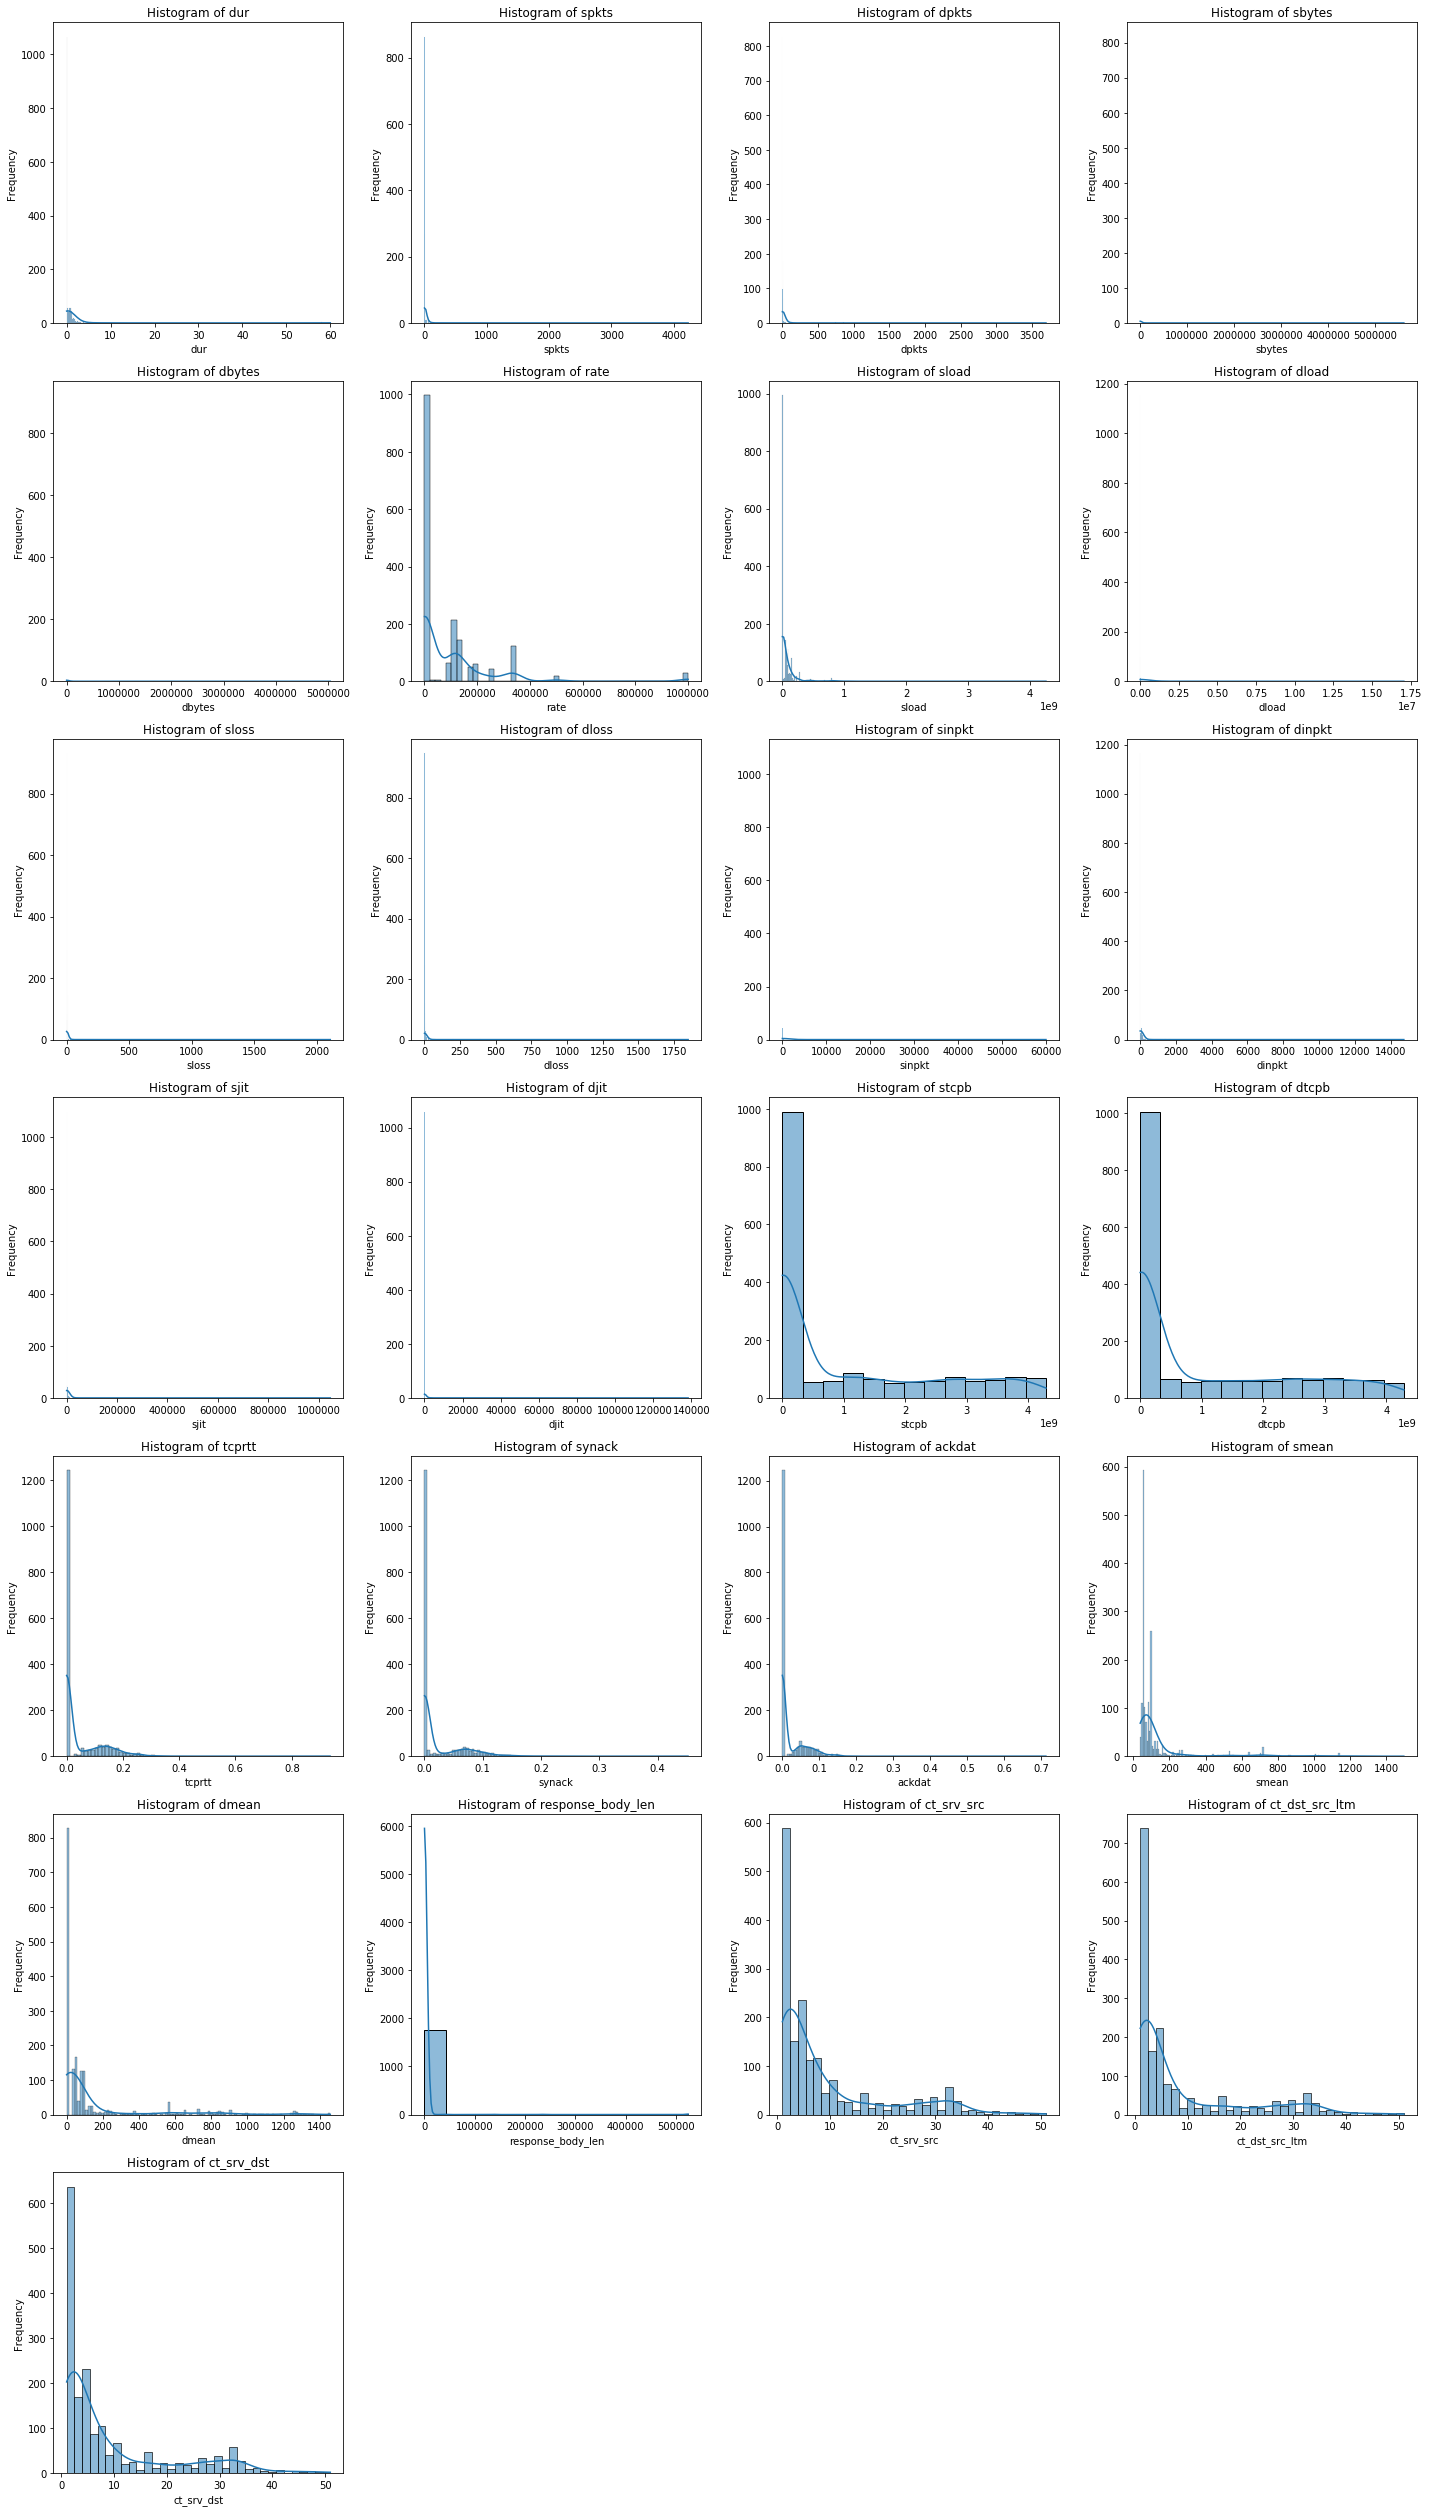

In [70]:
plot_histograms(x_train, continuous_cols)

### Histograms for Low Cardinality Columns

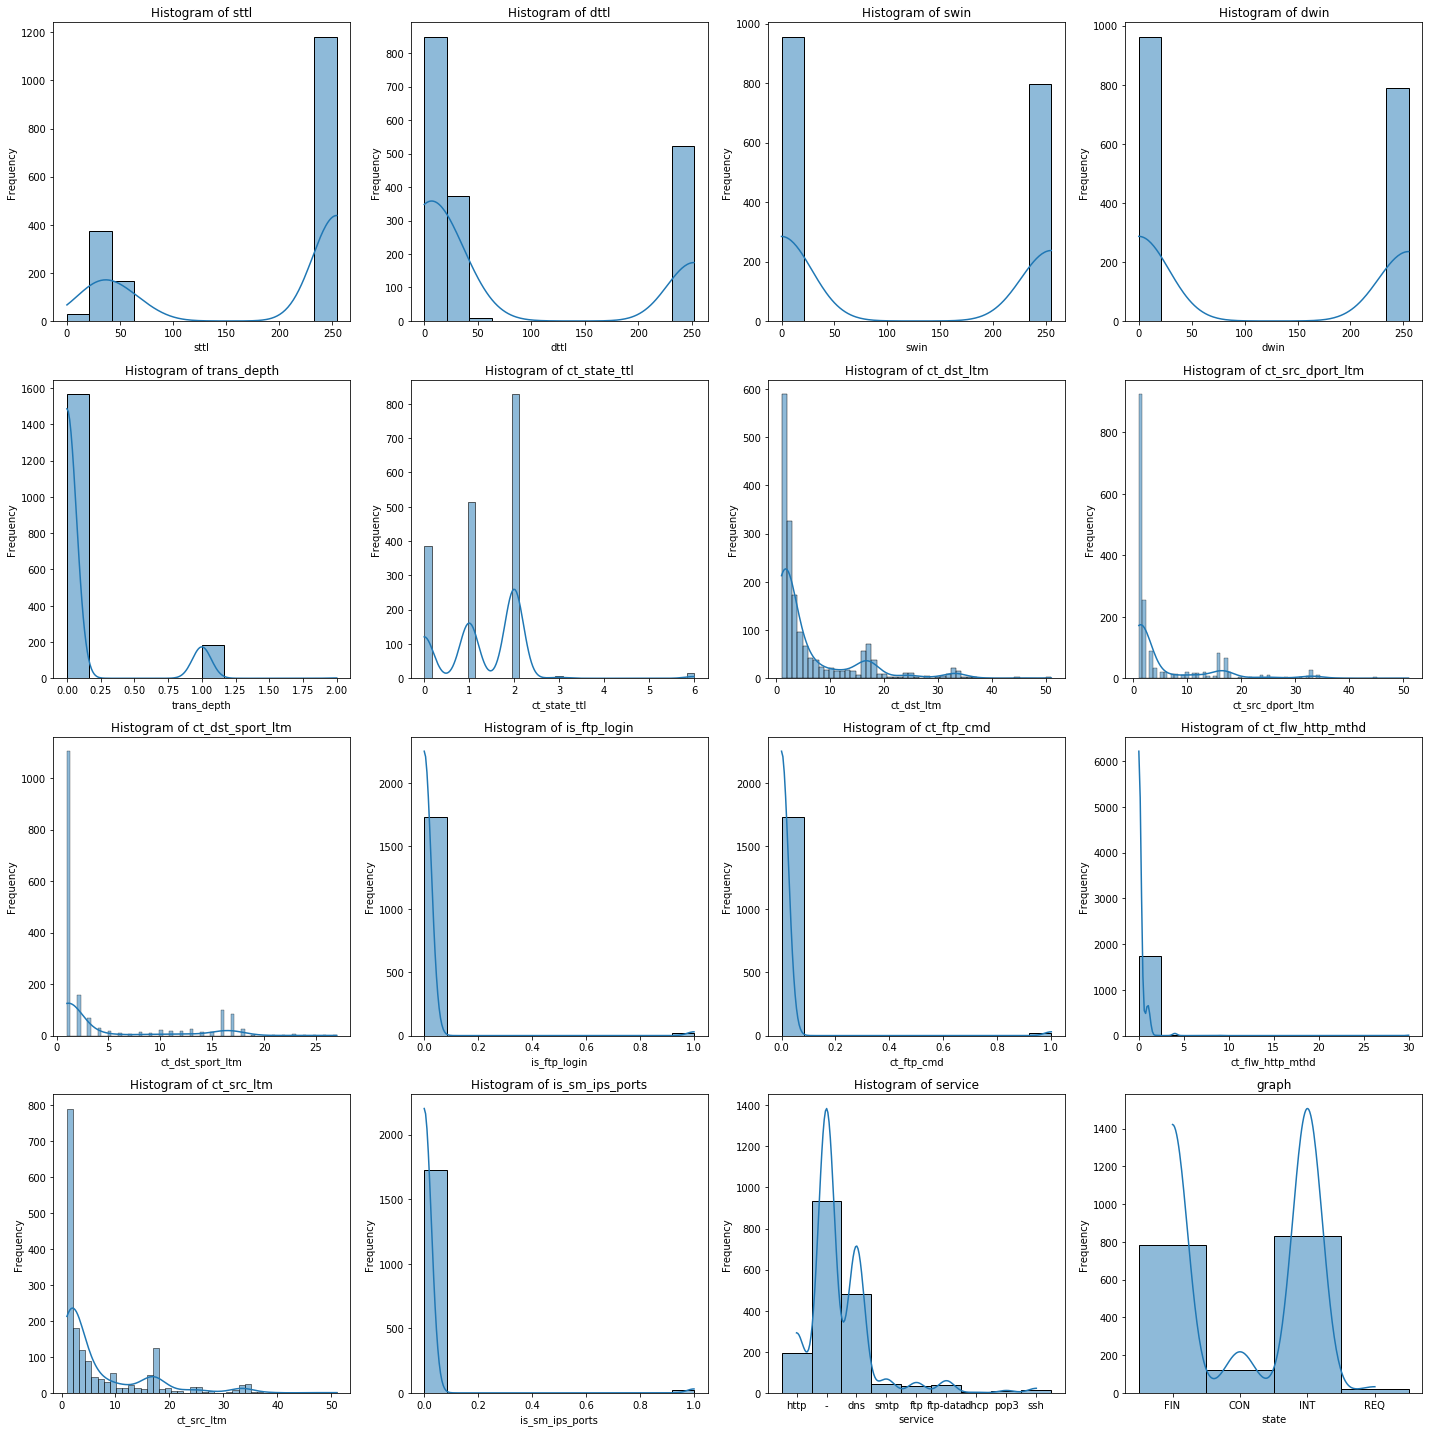

In [71]:
plot_histograms(x_train, low_cardinality_cols)

### Histograms for High Cardinality Columns

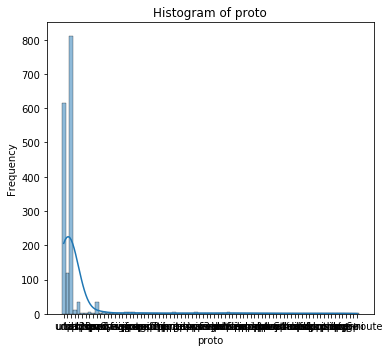

In [72]:
plot_histograms(x_train, high_cardinality_cols)

In [73]:
# checking if there are any outliers
outlier_data = []

for col in continuous_cols:
    lower_bound, upper_bound = show_outliers_iqr(train[col])
    lower_outliers_count = (x_train[col] < lower_bound).sum()
    upper_outliers_count = (x_train[col] > upper_bound).sum()
    non_outliers_count = len(x_train[col]) - (lower_outliers_count + upper_outliers_count)

    outlier_data.append({
        'Column': col,
        'Lower Bound Outlier %': f"{lower_outliers_count/len(x_train[col]):.2f}",
        'Upper Bound Outlier %': f"{upper_outliers_count/len(x_train[col]):.2f}",
        'Non-Outlier %': f"{non_outliers_count/len(x_train[col]):.2f}"
    })

# significant outliers
outlier_df = pd.DataFrame(outlier_data)
outlier_df_high = outlier_df[outlier_df['Upper Bound Outlier %'] > f'{OUTLIER_THRESHOLD}']
outlier_df_low = outlier_df[outlier_df['Upper Bound Outlier %'] < f'{OUTLIER_THRESHOLD}']
non_outlier_df = outlier_df[outlier_df['Upper Bound Outlier %'] == '0.00']
# outlier_df

In [74]:
outlier_df

,Column,Lower Bound Outlier %,Non-Outlier %,Upper Bound Outlier %
0,dur,0.00,0.91,0.09
1,spkts,0.00,0.86,0.14
2,dpkts,0.00,0.88,0.12
3,sbytes,0.00,0.87,0.13
4,dbytes,0.00,0.84,0.16
5,rate,0.00,0.90,0.10
6,sload,0.00,0.92,0.08
7,dload,0.00,0.78,0.22
8,sloss,0.00,0.94,0.06
9,dloss,0.00,0.84,0.16


In [75]:
print('non_outliers/ outlier_high /outlier_low')
print(non_outlier_df.shape, outlier_df_high.shape, outlier_df_low.shape)

non_outliers/ outlier_high /outlier_low
(2, 4) (15, 4) (10, 4)


Feature with highest absolute correlation to 'label': 
sttl                0.686880
ct_state_ttl        0.579612
dload               0.391986
ct_dst_sport_ltm    0.356180
swin                0.340185
Name: label, dtype: float64
Highest correlation coefficient: 0.6869


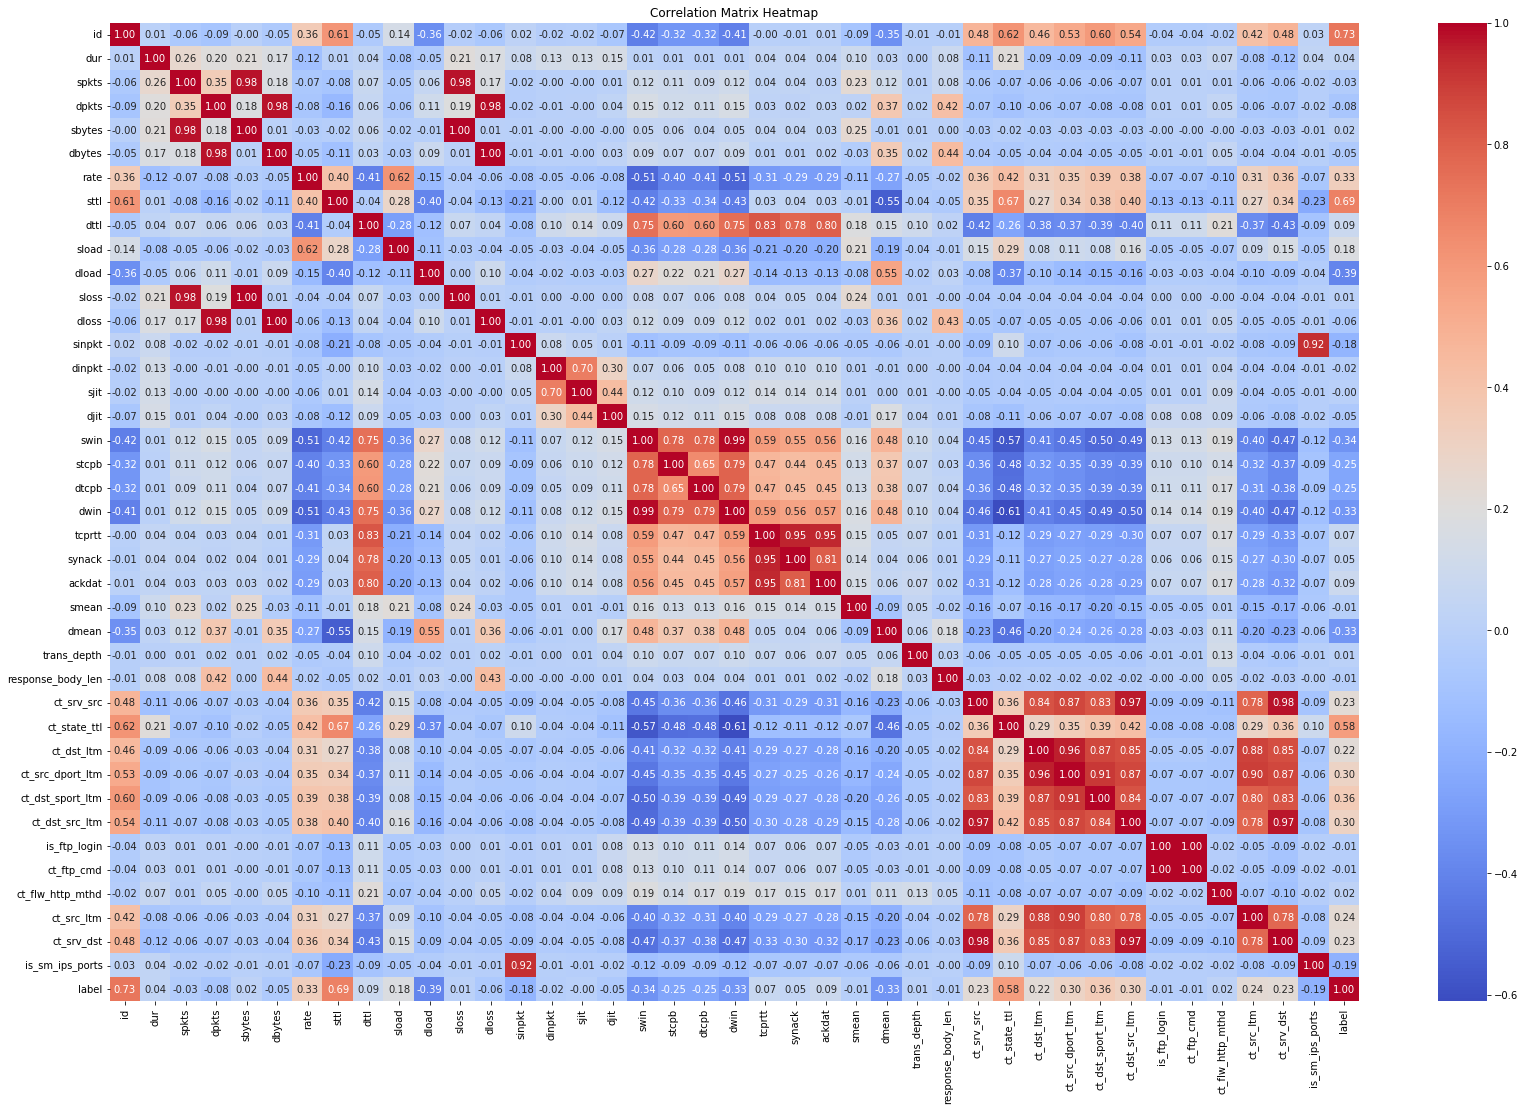

In [76]:
# Select only numerical columns before calculating correlation
corr_matrix = train.select_dtypes(include=[np.number]).corr()

# Get correlations with the 'label' column
label_correlations = corr_matrix['label'].drop('label').drop('id') # Exclude self-correlation

# Find the feature with the highest absolute correlation
top5_features = label_correlations.abs().nlargest(5)
highest_corr_value = top5_features.max()
print(f"Feature with highest absolute correlation to 'label': \n{top5_features}")
print(f"Highest correlation coefficient: {highest_corr_value:.4f}")

# 3. Plot the heatmap
plt.figure(figsize=(28, 18)) # Adjust figure size if needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

Feature with highest absolute correlation to 'label': 
sttl_ct_dst_sport_ltm_add            0.691310
sttl_ct_state_ttl_add                0.687989
sttl_swin_ratio                      0.469871
ct_state_ttl_ct_dst_sport_ltm_add    0.419844
dload_swin_add                       0.391999
Name: label, dtype: float64
Highest correlation coefficient: 0.6913


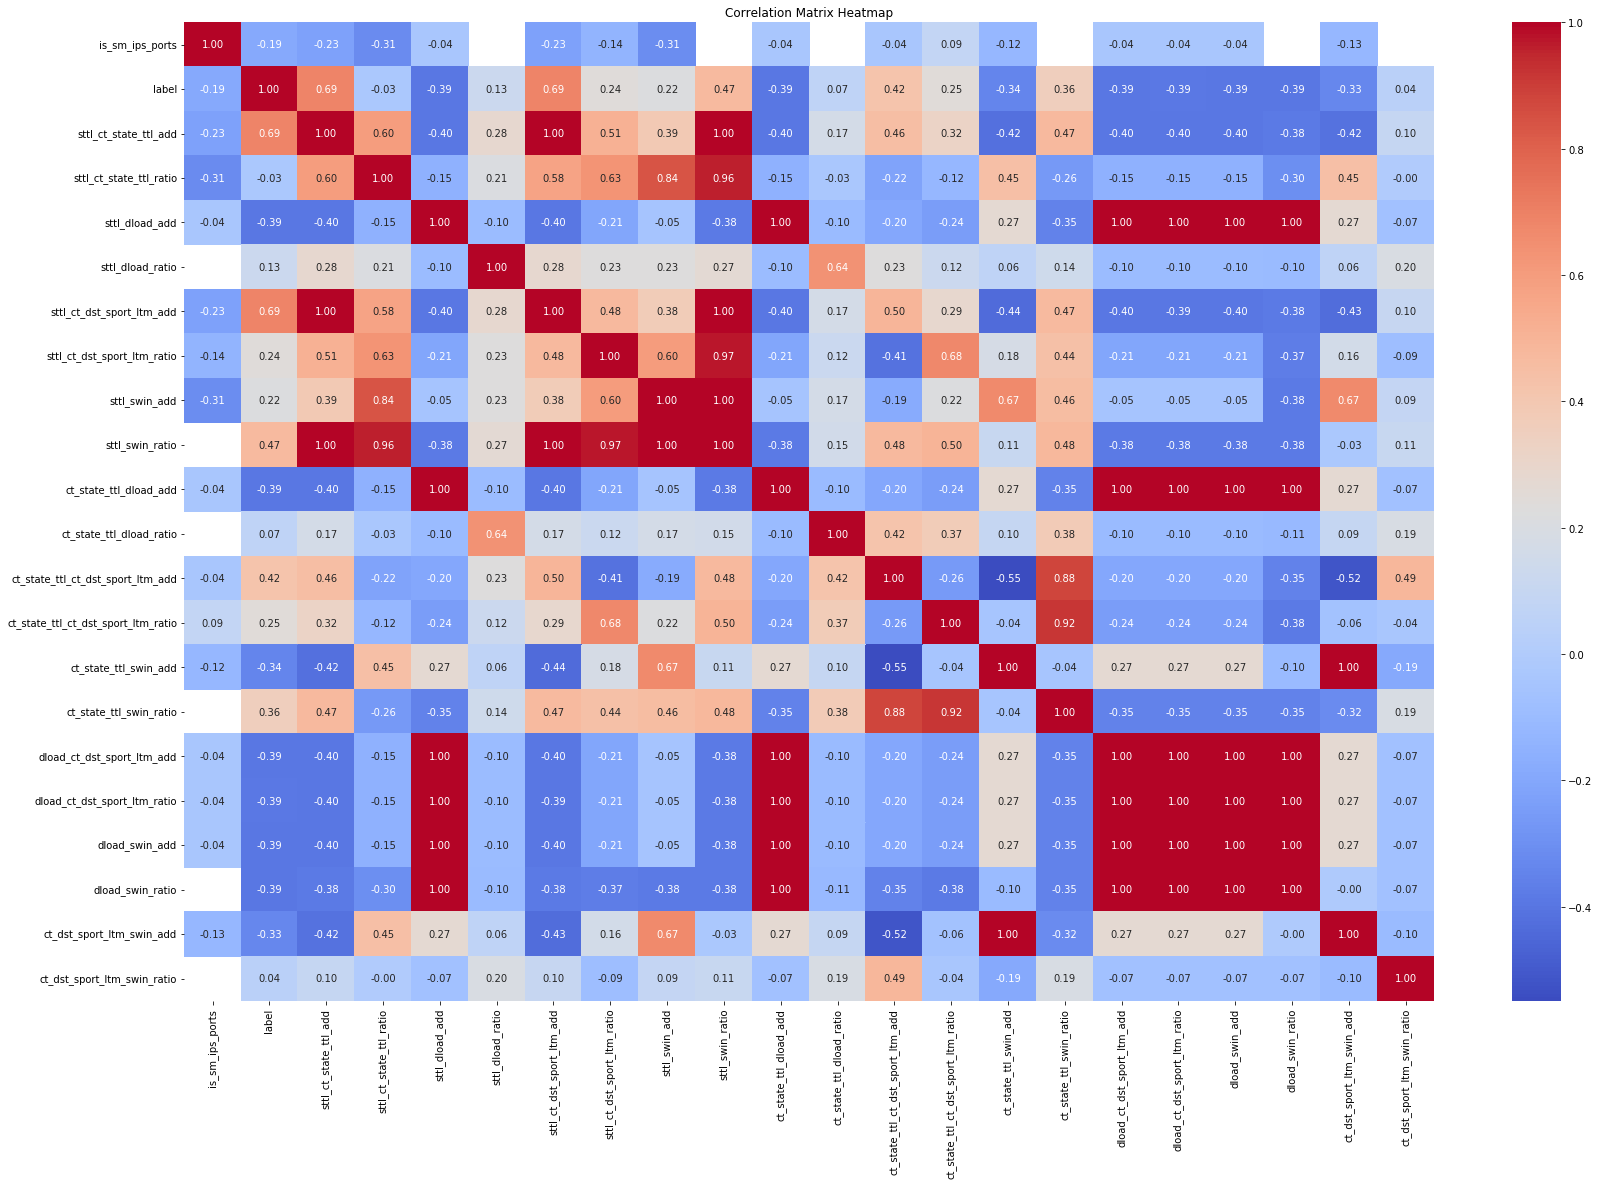

In [77]:
from itertools import combinations

pairs = combinations(top5_features.index, 2)

# Initialize temp with numerical columns from train. Correcting the TypeError here.
temp = train.select_dtypes(include=[np.number]).copy() # Use .copy() to avoid SettingWithCopyWarning later if modifying

for pair in pairs:
    feature1, feature2 = pair

    add_trans = Add_feature(feature1, feature2)
    ratio_trans = Ratio_feature(feature1, feature2)

    # Apply Add_feature and rename the new column to be unique
    transformed_add = add_trans.fit_transform(temp.copy()) # Use a copy to prevent in-place modification within transformer's fit_transform
    add_feature_name = f'{feature1}_{feature2}_add'
    temp[add_feature_name] = transformed_add['new_feature']

    # Apply Ratio_feature and rename the new column to be unique
    transformed_ratio = ratio_trans.fit_transform(temp.copy()) # Use a copy
    ratio_feature_name = f'{feature1}_{feature2}_ratio'
    temp[ratio_feature_name] = transformed_ratio['new_feature']

# After generating all new features, drop the original top5_features columns
# Correcting the inplace=True issue: assign the result back to temp.
# Use list() for columns and errors='ignore' to handle cases where top5_features.index might contain columns not in temp.
temp = temp.drop(columns=numerical_cols[:-1], errors='ignore')

# plot a coefficient matrix for temp
temp_corr_matrix = temp.corr()

# 3. Plot the heatmap
label_correlations = temp_corr_matrix['label'].drop('label') # Exclude self-correlation
top5_features = label_correlations.abs().nlargest(5)
highest_corr_value = top5_features.max()
print(f"Feature with highest absolute correlation to 'label': \n{top5_features}")
print(f"Highest correlation coefficient: {highest_corr_value:.4f}")

plt.figure(figsize=(28, 18)) # Adjust figure size if needed
sns.heatmap(temp_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

(17534, 40)
(17534, 40)
(17534, 39)
(17534, 39)


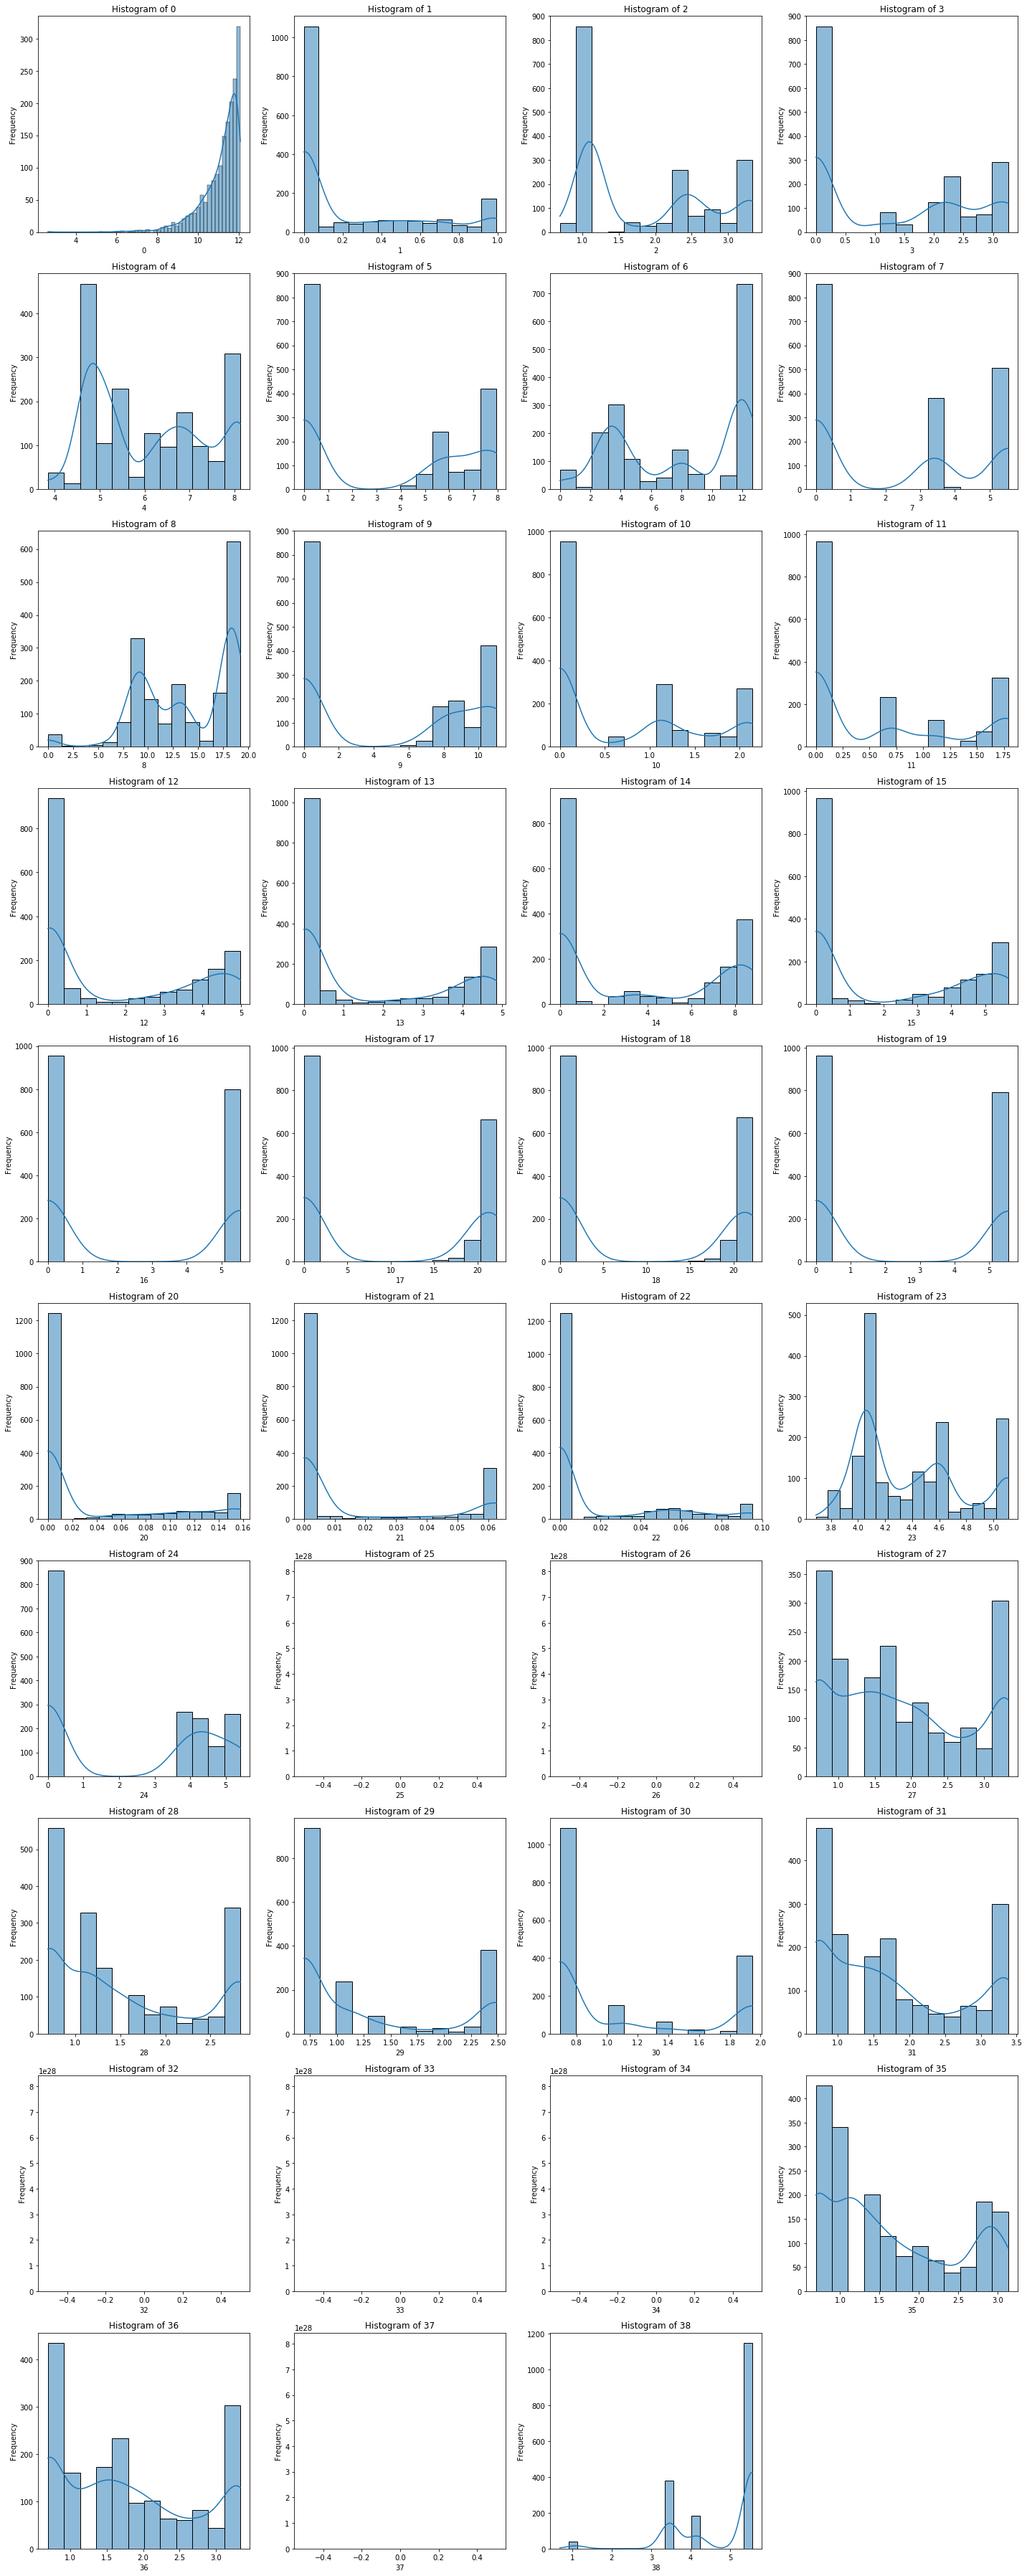

(17534, 3)
Pearson selection: 49 -> 37 features (threshold=0.1)


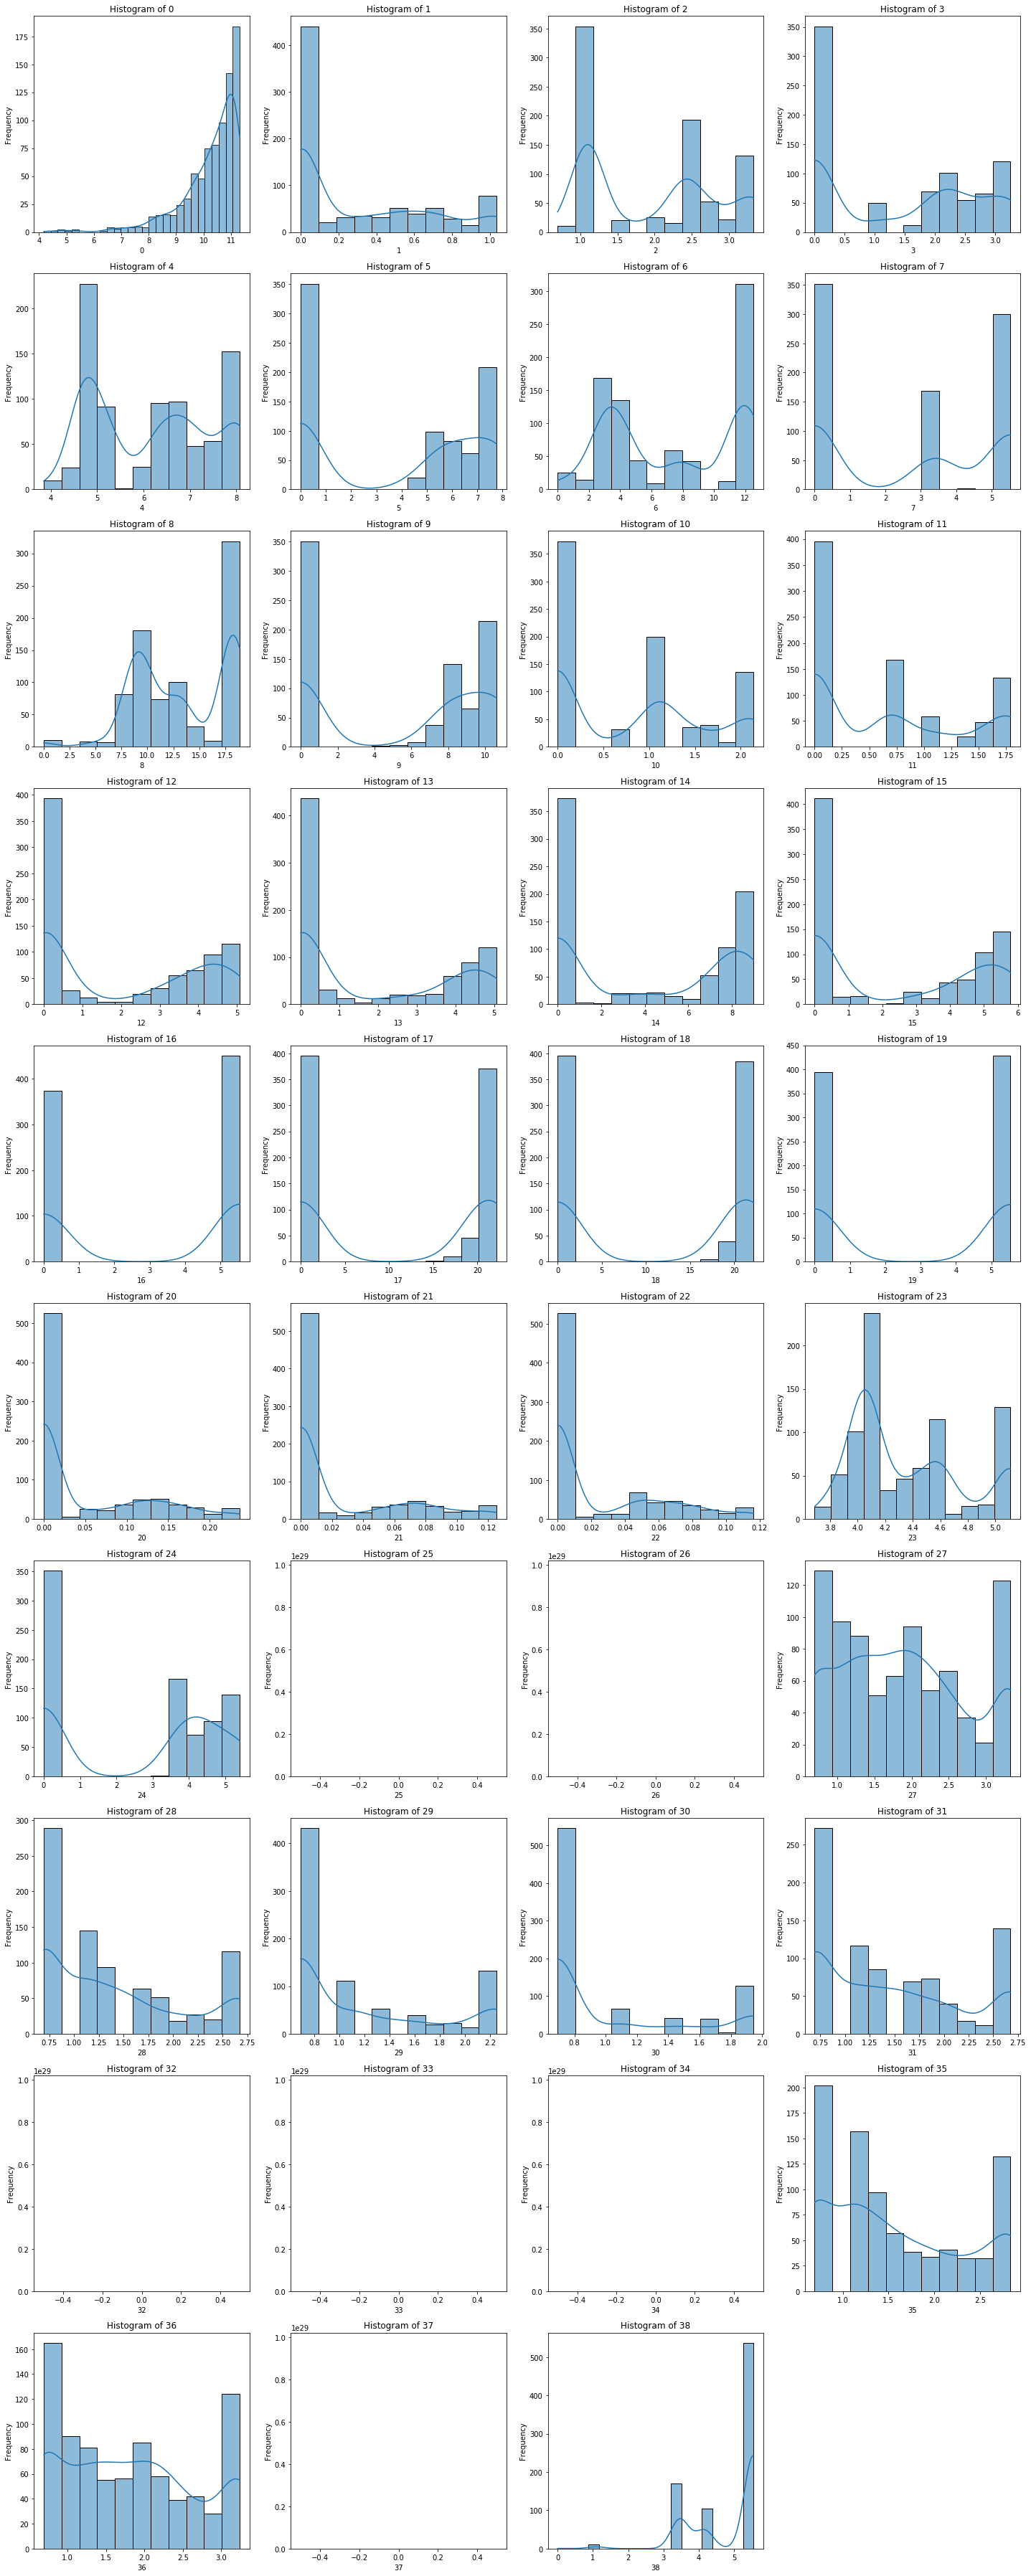

In [172]:
from sklearn.preprocessing import OneHotEncoder

column_modifier_core = Pipeline([
    ("ttl_sum", Add_feature('sttl', 'ct_state_ttl')),
    ("drop_original", ColumnTransformer(
        transformers=[
            ("drop_columns", "drop", ["sttl", "ct_state_ttl"])
        ], remainder="passthrough"
    ))
])

# Define the numerical pipeline
numerical_pipeline = Pipeline([
    ("capping", capping(numerical_cols)),
    # ("filtering", filtering(numerical_cols)),
    ("column_mod", column_modifier_core),
    ("logrithmic_transform", SafeLogTransformer()),
    ("plot", Plot(frac=0.1, title='Histograms of preprocessed features'))
])

# Define the categorical pipeline
categorical_pipeline = Pipeline([
    ("bin_rare", Threshold_binning(threshold=BIN_THRESHOLD)),
    ("one_hot_encoding", OneHotEncoder(handle_unknown='ignore'))
    # ("ordinal", OrdinalEncoder(
    #     handle_unknown="use_encoded_value",
    #     unknown_value=-1
    # ))
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_cols),
        ("cat", categorical_pipeline, non_numerical_cols)
    ],
    remainder='passthrough'
)

# Re-define the main preprocessing pipeline
preprocessing = Pipeline([
    ("feature_preprocessing", preprocessor),
    # ("plot", Plot(frac=0.1, title='Histograms of preprocessed features')),
    ("pearson_selection", Pearson_feature_selection(threshold=FEATURE_THRESHOLD))
])

# run pipeline
encoded_x_train = preprocessing.fit_transform(x_train, y_train['label'])
encoded_x_test = preprocessing.transform(x_test)

In [173]:
print(encoded_x_train.shape)

(17534, 37)


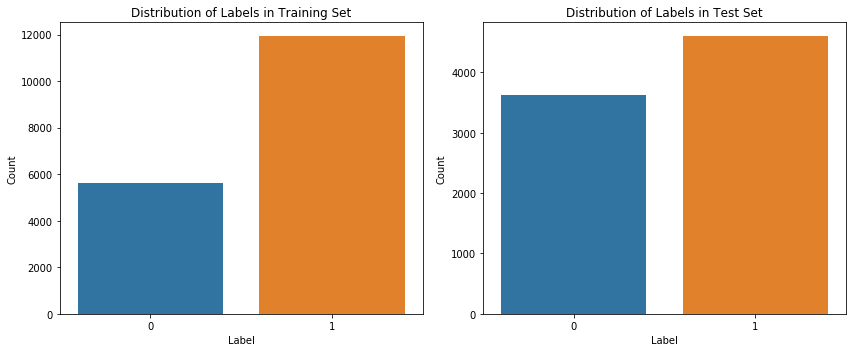

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize label distribution for y_train
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train['label'])
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')

# Visualize label distribution for y_test
plt.subplot(1, 2, 2)
sns.countplot(x=y_test['label'])
plt.title('Distribution of Labels in Test Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [170]:
# !pip install xgboost #uncomment if error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hyperparameters = {}

In [171]:
param_grid = {
    'max_depth': [10,30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],

}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid=param_grid, cv=cv_strategy)
grid_search.fit(encoded_x_train, y_train['label'])
hyperparameters['Random_Forest'] = grid_search.best_estimator_

In [152]:
print(grid_search.best_params_)

{'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [157]:
# Logistic Regression classifier
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200]
}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), param_grid=param_grid_lr, cv=cv_strategy)
grid_search_lr.fit(encoded_x_train, y_train['label'])
hyperparameters['Logistic_Regression'] = grid_search_lr.best_estimator_

print("Logistic Regression best parameters:")
print(grid_search_lr.best_params_)

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

Logistic Regression best parameters:
{'C': 100, 'max_iter': 100, 'solver': 'liblinear'}


C:\Users\User\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [175]:
# XGBoost Classifier
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

grid_search_xgb = GridSearchCV(XGBClassifier(class_weight='balanced', use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid=param_grid_xgb, cv=cv_strategy, verbose=1, n_jobs=-1)
grid_search_xgb.fit(encoded_x_train, y_train['label'])
hyperparameters['XGBoost'] = grid_search_xgb.best_estimator_

print("XGBoost best parameters:")
print(grid_search_xgb.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


KeyboardInterrupt: 

Generating Confusion Matrix for Random_Forest


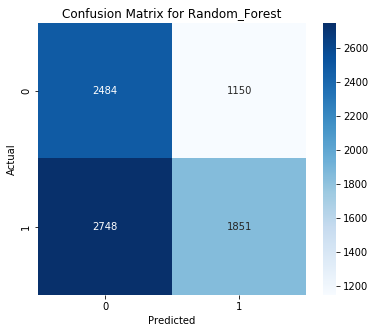

Generating Confusion Matrix for XGBoost


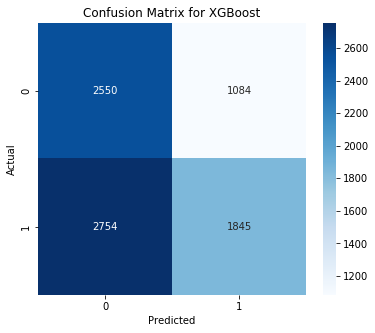

Generating Confusion Matrix for Logistic_Regression


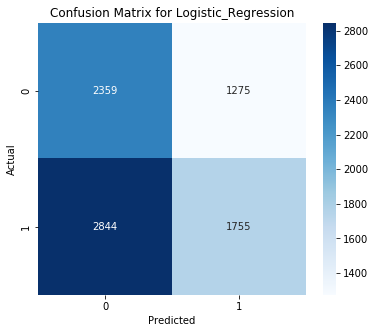

In [158]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, model_estimator in hyperparameters.items():
    print(f"Generating Confusion Matrix for {model_name}")

    # Make predictions on the encoded test set
    y_pred = model_estimator.predict(encoded_x_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test['label'], y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [160]:
results = []

for model_name, model_estimator in hyperparameters.items():
    print(f"Evaluating {model_name}...")

    # Make predictions on the encoded test set
    y_pred = model_estimator.predict(encoded_x_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test['label'], y_pred)
    precision = precision_score(y_test['label'], y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test['label'], y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test['label'], y_pred, average='weighted', zero_division=0)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

Evaluating Random_Forest...
Evaluating XGBoost...
Evaluating Logistic_Regression...

Model Performance Comparison:
Accuracy  F1-Score                Model  Precision    Recall
0.526540  0.519432        Random_Forest   0.554106  0.526540
0.533827  0.525670              XGBoost   0.564079  0.533827
0.499696  0.492664  Logistic_Regression   0.523674  0.499696
